In [1]:
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Conv1D,MaxPooling1D
from keras.layers.core import Dense, Activation,Dropout ,Flatten
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint,TensorBoard, ReduceLROnPlateau,EarlyStopping
from keras.applications import Xception
from keras import regularizers
from keras import backend as K
import keras
import numpy as np
import pandas as pd
import cv2
import os
import glob
import math
seed = 7
np.random.seed(seed)


/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


ImportError: No module named 'cv2'

In [6]:
train_data = pd.read_csv('train.tsv',sep='\t')
test_data = pd.read_csv('test.tsv',sep='\t')


In [10]:
Sentiment_words=[]
for row in train_data['Sentiment']:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('neutral')
    elif row == 2:
        Sentiment_words.append('somewhat negative')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
train_data['Sentiment_words'] = Sentiment_words

In [98]:
word_count=pd.value_counts(train_data['Sentiment_words'].values, sort=False)

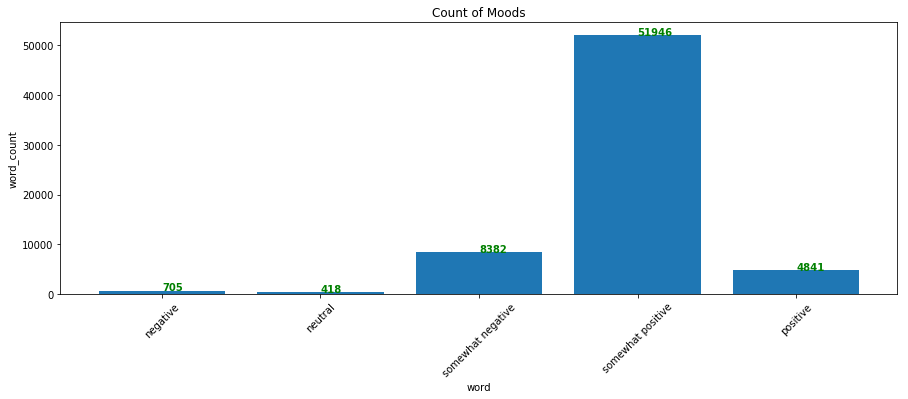

In [97]:
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index,word_count,color = 'blue')
plt.xticks(Index,['negative','neutral','somewhat negative','somewhat positive','positive'],rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods')
plt.bar(Index, word_count)
for a,b in zip(Index, word_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

In [14]:
def review_to_words(raw_review): 
    review =raw_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))

In [16]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/devendra/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
corpus= []
for i in range(0, 156060):
    corpus.append(review_to_words(train_data['Phrase'][i]))


In [19]:
corpus


['series escapade demonstrating adage good goose also good gander occasionally amuses none amount much story',
 'series escapade demonstrating adage good goose',
 'series',
 '',
 'series',
 'escapade demonstrating adage good goose',
 '',
 'escapade demonstrating adage good goose',
 'escapade',
 'demonstrating adage good goose',
 'demonstrating adage',
 'demonstrating',
 'adage',
 '',
 'adage',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 'good',
 'goose',
 '',
 'goose',
 'goose',
 'also good gander occasionally amuses none amount much story',
 'also good gander occasionally amuses none amount much story',
 'also',
 'also',
 'good gander occasionally amuses none amount much story',
 'gander occasionally amuses none amount much story',
 'gander occasionally amuses none amount much story',
 'gander',
 'gander',
 'gander',
 '',
 'occasionally amuses none amount much story',
 '',
 '',
 '',
 '',
 'occasionally amuses none amount much story',
 'occasionally',
 '

In [12]:
train_data.head()


PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment    Sentiment_words  
0          1            neutral  
1          2  somewhat negative  
2          2  somewhat negative  
3          2  somewhat negative  
4          2  somewhat negative

In [22]:
corpus1= []
for i in range(0, 66292):
    corpus1.append(review_to_words(test_data['Phrase'][i]))


In [23]:
train_data['new_Phrase']=corpus


In [24]:
train_data.drop(['Phrase'],axis=1,inplace=True)

In [25]:
positive=train_data[train_data['Sentiment_words']==('positive')]

In [26]:
positive

PhraseId  SentenceId  Sentiment Sentiment_words  \
63            64           2          4        positive   
66            67           2          4        positive   
74            75           2          4        positive   
77            78           2          4        positive   
117          118           4          4        positive   
118          119           4          4        positive   
123          124           4          4        positive   
166          167           6          4        positive   
172          173           6          4        positive   
176          177           6          4        positive   
180          181           6          4        positive   
182          183           6          4        positive   
183          184           6          4        positive   
280          281          11          4        positive   
303          304          11          4        positive   
352          353          13          4        positive   
355          356          13          4        positive   
358          359          13          4        positive   
362          363          13          4        positive   
384          385          14          4        positive   
419          420          15          4        positive   
444          445          16          4        positive   
445          446          16          4        positive   
449          450          16          4        positive   
452          453          16          4        positive   
454          455          16          4        positive   
480          481          18          4        positive   
497          498          18          4        positive   
499          500          18          4        positive   
551          552          21          4        positive   
...          ...         ...        ...             ...   
155333    155334        8502          4        positive   
155367    155368        8503          4        positive   
155395    155396        8505          4        positive   
155397    155398        8505          4        positive   
155527    155528        8513          4        positive   
155529    155530        8513          4        positive   
155530    155531        8513          4        positive   
155570    155571        8515          4        positive   
155571    155572        8515          4        positive   
155593    155594        8516          4        positive   
155594    155595        8516          4        positive   
155596    155597        8516          4        positive   
155597    155598        8516          4        positive   
155598    155599        8516          4        positive   
155669    155670        8520          4        positive   
155676    155677        8520          4        positive   
155694    155695        8521          4        positive   
155696    155697        8521          4        positive   
155699    155700        8522          4        positive   
155700    155701        8522          4        positive   
155701    155702        8522          4        positive   
155705    155706        8523          4        positive   
155785    155786        8527          4        positive   
155803    155804        8528          4        positive   
155808    155809        8528          4        positive   
155946    155947        8537          4        positive   
155955    155956        8538          4        positive   
155961    155962        8538          4        positive   
156007    156008        8541          4        positive   
156010    156011        8541          4        positive   

                                               new_Phrase  
63      quiet introspective entertaining independent w...  
66           quiet introspective entertaining independent  
74                                           entertaining  
77                                          worth seeking  
117     positively thrilling combination ethnogra

In [27]:
words = ' '.join(positive['new_Phrase'])
split_word = " ".join([word for word in words.split()])


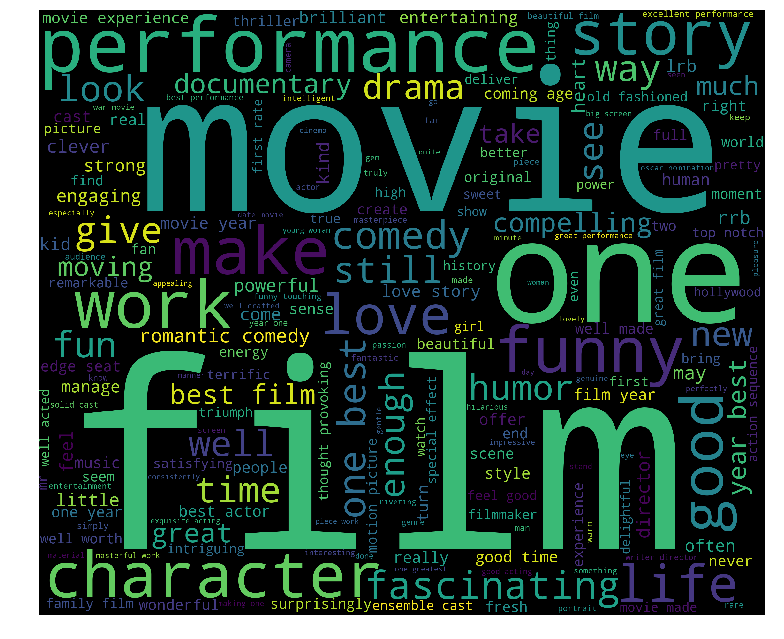

In [34]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(split_word)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [35]:
pos=positive['new_Phrase']

In [37]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000)

In [38]:
pos_words = vectorizer.fit_transform(pos)
pos_words = pos_words.toarray()
pos= vectorizer.get_feature_names()

In [51]:
dist = np.sum(pos_words, axis=0)
for tag, count in zip(pos, dist):
    print (tag,count)

ability 20
able 32
absolute 9
absolutely 24
absorbing 18
accept 10
accessible 16
acclaim 9
accomplish 5
accomplished 23
accomplishes 7
accomplishment 17
accurate 9
achievement 30
achieves 5
achingly 7
across 12
act 29
acted 43
acting 101
action 93
actor 130
actress 14
actually 45
acute 8
adam 7
adaptation 22
add 17
addition 13
admirable 16
admire 7
adorably 7
adorns 7
adrenalin 6
adrenaline 6
adult 35
adventure 54
adventurous 17
aerial 7
affecting 9
affection 11
affirming 10
affirms 5
age 84
agenda 7
aggrandizing 7
ago 9
ahead 10
aimed 5
air 10
alike 5
alive 20
allegory 7
allen 15
allows 19
alluring 7
almost 50
alone 8
along 29
also 88
alternately 6
always 43
amazing 35
amazingly 11
ambiguity 6
ambitious 18
america 18
american 63
among 19
amount 16
amused 9
amusing 57
anchor 6
anderson 6
angst 10
animal 10
animated 28
animation 24
anime 6
another 43
answer 11
antic 7
anybody 5
anyone 35
anything 31
apart 8
apex 5
aplomb 11
apocalypse 8
apparent 6
appeal 15
appealing 27
appear 8
appreci

sexual 11
sexy 27
shape 12
shaped 11
share 12
sharp 18
sheer 15
sheerly 6
shifting 9
shimmering 9
shine 13
shining 9
shiver 6
shock 8
shocking 6
short 25
shot 51
show 47
showtime 6
shyamalan 6
sick 11
side 26
sight 12
sign 9
significance 7
significant 9
significantly 6
silly 17
silver 6
simple 35
simply 35
simultaneously 17
since 50
sincere 17
sincerity 6
singer 7
singing 18
single 7
situation 14
skilfully 6
skill 32
skillful 9
skillfully 10
skin 10
sleepless 6
slice 11
slightly 6
slowly 6
small 29
smart 106
smarter 6
smartly 19
smile 22
sneak 9
soap 6
soar 18
sobering 9
social 14
soderbergh 9
solid 106
solidly 15
somber 6
somehow 8
someone 6
something 90
sometimes 39
somewhat 8
son 13
song 10
soon 7
sophisticated 20
sort 15
soul 27
sound 16
soundtrack 12
space 19
spader 7
spare 13
sparkling 16
special 44
spectacle 9
spectacular 19
spectacularly 12
spell 10
spellbinding 9
spider 15
spielberg 26
spike 9
spin 12
spirit 64
spirited 15
spiritual 16
spirituality 6
splendid 36
splendor 9
spo

In [53]:
postive_new= pd.DataFrame(dist)

In [55]:
postive_new.columns=['word_count']

In [56]:
postive_new['word'] = pd.Series(pos, index=postive_new.index)

In [58]:
postive_new1=postive_new[['word','word_count']]

In [59]:
postive_new1.head()

word  word_count
0     ability          20
1        able          32
2    absolute           9
3  absolutely          24
4   absorbing          18

In [60]:
top_30_words=postive_new1.sort_values(['word_count'],ascending=[0])

In [61]:
top_30_words.head(30)

word  word_count
652           film        1104
1149         movie         757
1223           one         517
1280   performance         472
161           best         394
715          funny         347
760           good         339
1933          well         317
1672         story         280
1990          year         275
1972          work         274
315         comedy         271
1067          make         249
774          great         220
262      character         215
1045          love         202
1020          life         183
1789          time         182
552   entertaining         168
712            fun         168
811          heart         161
1023          like         151
476          drama         147
1483           rrb         146
244           cast         146
458       director         143
1057          made         141
1050           lrb         137
1152        moving         131
21           actor         130

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
x__train = cv.fit_transform(corpus).toarray()
x__test= cv.fit_transform(corpus1).toarray()
y = train_data.iloc[:, 2].values

In [73]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x__train, y, test_size = 0.40, random_state = 0)

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_real_pred = classifier.predict(x__test)


/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [90]:
test_data['Sentiment'] = y_real_pred

In [92]:
Sentiment_words=[]
for row in test_data['Sentiment']:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('neutral')
    elif row == 2:
        Sentiment_words.append('somewhat negative')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
test_data['Sentiment_words'] = Sentiment_words

In [95]:
test_data.to_csv('result.csv', sep='\t')

In [86]:
mse = ((y_pred - y_test) ** 2).mean()

In [87]:
rmse = sqrt(mse)

In [89]:
rmse

0.8045987901576522